# Compute LST and NDVI in NYC for Landsat 5

## Introduction 

In this notebook, we compute LST for the New York City using *Landsat 5* data that is clipped to NYC boundaries. (Another notebook is used to compute LST with Landsat 8 data.) To compute LST, we follow the procedure outlined in McConnell's 2022 paper. The steps are 

- Convert Band 6 to Top of Atmosphere (TOA) spectral radiance using two constants from Landsat metadata
- Compute brightness temperature using TOA and 2 constants from metadata
- Compute NDVI using 
\begin{align}
\frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}} = \frac{\text{Band} \, 4 \, – \text{Band} \, 3}{\text{Band} \, 4 + \text{Band} \, 3} 
\end{align}
- Convert NDVI to vegetation fraction
- Compute emissivity using the formula specified in McConnell's paper
- Compute LST using brightness temperature, emissivity, and some constants also specified in McConnell's paper

The contents of this notebook are the following.

- In [Section 1](#import), we define functions to compute the outlined procedure
- In [Section 2](#test) we test the procedure on a single Landsat file and plot the result. 
- In [Section 3](#export) we compute LST and NDVI for all the Landsat files and export results. 

## Results

LST and NDVI are computed in this notebook and exported for later use. A heatmap of LST/NDVI can be generated in [Section 2](#test).

## Data

The data imported into this notebook is clipped Landsat data located in `02-data/landsat_clipped_nyc/`. These are raster files saved in `.tif` format. We import the files relevant to LST calculations with Landsat 5, which are bands 3, 4, and 6. We additionally import metadata for these Landsat files, which are `.txt` files.

Data is exported to the folders `02-data/ndvi_clipped_nyc` and `02-data/lst_clipped_nyc`. The exported filenames contain the parameter computed with the original Landsat filename. For example, the file `ndvi_LT05_L1TP_013032_19910801_20160929_01_T1.tif` contains the NDVI calculation in NYC for the Landsat file listed. 

In [2]:
import os
DIR_PARENT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIR_SCRIPTS = DIR_PARENT + "/01-scripts"

"""Push the directory to load helper scripts from"""
import sys
sys.path.append(DIR_SCRIPTS)

import helpers

import rioxarray as rxr
import xarray as xr
from xarray.core.dataarray import DataArray
import numpy as np

# For plotting
import matplotlib.pyplot as plt

# Import directories
DIR_DATA = DIR_PARENT + "/02-data"
DIR_RAW_CLIPPED_NYC = DIR_PARENT + "/02-data/landsat_clipped_nyc"

# Export directories
DIR_NDVI_CLIPPED_NYC = DIR_PARENT + "/02-data/ndvi_clipped_nyc"
DIR_LST_CLIPPED_NYC = DIR_PARENT + "/02-data/lst_clipped_nyc"

DIR_FIGS = DIR_PARENT + "/03-figs"

## 1. Import data and define functions <a id="import"></a>

In [3]:
landsat_filenames = []
helpers.get_filenames(DIR_RAW_CLIPPED_NYC, landsat_filenames)
landsat_filenames.sort()

# Filter clipped Landsat files by band
band3_filenames = [x for x in landsat_filenames if ("B3" in x and "LT05" in x)]
band4_filenames = [x for x in landsat_filenames if ("B4" in x and "LT05" in x)]
band6_filenames = [x for x in landsat_filenames if ("B6" in x and "LT05" in x)]

band3_filenames.sort()
band4_filenames.sort()
band6_filenames.sort()

print("Number of B3 files = ", len(band3_filenames))
print("Number of B4 files = ", len(band4_filenames))
print("Number of B6 files = ", len(band6_filenames))

def get_landsat_identifier(bname: str) -> str:
    """
    in: name = an element of bandX_filenames, where X = 1,2,3
    out: the Landsat identifer. 
        E.g. "LT05_L1TP_014032_20110831_20160831_01_T1"
    """
    return "_".join(bname.split("/")[-1].split(".")[0].split("_")[2:-1])

def import_txt_as_dict(fname: str) -> dict:
    """
    This function imports a text file where each line is of the form
        'key1 = val1'
    as a dictionary. It splits the line at the equals sign and
    assigns key-value pairs.
    
    in: fname = filename for Landsat metadata
    out: dictionary
    """
    d = {}
    with open(fname) as f:
        for line in f:
            if len(line.split("="))>1:
                (key, val) = line.split("=")
                d[key] = val.split("\n")[0]
    return d

def open_mtl_file(bname: str) -> dict:
    """
    This function opens Landsat metadata as a dictionary.
    
    in: bname = a Landsat band filename 
    out: dictionary
    """
    dirname = "/".join(bname.split("/")[:-1])
    fileroot = get_landsat_identifier(bname)
    return import_txt_as_dict(dirname+"/"+fileroot+"_MTL"+".txt")

def open_masked_band(bname: str, mask_value: float) -> DataArray:    
    """
    This function opens the band given by `filename` masking the 
    values specified by `mask_value`
    
    in: bname = Landsat band filename (element of bandX_fileanames),
    mask_value = which is zero for all our data.
    out: a masked data array
    """
    band = rxr.open_rasterio(bname)
    data_xarray = xr.DataArray(np.ma.masked_where(band==mask_value, \
                                                  band).squeeze(),
        dims=["y","x"],
        coords={"x":band["x"].data,
               "y":band["y"].data,
               "band":1,
               "spatial_ref":0},
        attrs=band.attrs)
    data_xarray.rio.write_crs(band.rio.crs, inplace=True)
    return data_xarray

def compute_toa_radiance(band: DataArray, meta: dict) -> DataArray:
    """
    Compute Top-of-Atmosphere (TOA) radiance.
    
    in: an xarray DataArray object for the masked Landsat band 
    data, and the metadata dictionary
    out: an xarray DataArray of TOA radiance
    """
    Ml = float(meta["    RADIANCE_MULT_BAND_6 "])
    Al = float(meta["    RADIANCE_ADD_BAND_6 "])
    return Ml*band + Al

def compute_brightness_temp(toa: DataArray, meta: dict) -> DataArray:
    """
    Compute brightness temperature.
    
    in: TOA radiance and metadata for a Landsat file
    out: an xarray DataArray of the brightness temperature
    """
    K1 = float(meta["    K1_CONSTANT_BAND_6 "])
    K2 = float(meta["    K2_CONSTANT_BAND_6 "])
    return K2/np.log(K1/toa + 1)

def compute_ndvi(nir: DataArray, red: DataArray, 
                 meta: dict) -> DataArray:
    """
    in: the near-infrared and red bands of the Landsat data, and
    Landsat metadata imported as a dictionary.
    out: the NDVI 
    """
    nir_toa = compute_toa_radiance(nir, meta)
    red_toa = compute_toa_radiance(red, meta)
    return (nir_toa-red_toa)/(nir_toa+red_toa)

def compute_vegetation_fraction(ndvi: DataArray) -> DataArray:
    """
    in: the NDVI for a Landsat scene
    out: The vegetation fraction for a Landsat scene
    """
    ndvi_min = np.min(ndvi)
    ndvi_max = np.max(ndvi)
    return (ndvi-ndvi_min/(ndvi_max-ndvi_min))**2

def compute_emissivity(vf: DataArray) -> DataArray:
    """
    in: Vegetation fraction for a Landsat scene
    out: the emissivity for a Landsat scene
    """
    return 0.004*vf + 0.986481

def compute_lst(w: float, bt: DataArray, 
                emiss: DataArray) -> DataArray:
    """
    in: w = midpoint of the thermal band converted to meters, 
    bt = brightness temperature for a Landsat scene, and emiss = 
    emissivity for a Landsat scene
    out: the LST for a Landsat scene
    """
    Q = 1.438*10**(-2)
    return bt/(1 + w*bt*np.log(emiss)/Q)

Number of B3 files =  92
Number of B4 files =  92
Number of B6 files =  92


## 2. Test the computation for a single date <a id="test"></a>

In [4]:
"""Test the program by selecting a single file"""
select = 1 # OPTIONS: Integer between 0 and (Number of Landsat files) - 1.

# Open band 6 and its metadata file
band6_test = open_masked_band(band6_filenames[select], 0.0)
mtl_test = open_mtl_file(band6_filenames[select])

# Open nir and red
band4_test = open_masked_band(band4_filenames[select], 0.0)
band3_test = open_masked_band(band3_filenames[select], 0.0)

print(band3_filenames[select])
print(band4_filenames[select])
print(band6_filenames[select])

# Begin LST equations
toa = compute_toa_radiance(band6_test, mtl_test)
bt = compute_brightness_temp(toa, mtl_test)

ndvi = compute_ndvi(band4_test, band3_test, mtl_test)

vf = compute_vegetation_fraction(ndvi)
emiss = compute_emissivity(vf)
w = 11.45*10**-6 # From USGS, Band 6 wavelengths = 10.40 - 12.50 µm
lst = compute_lst(w, bt, emiss)

exportname_lst = DIR_LST_CLIPPED_NYC + "/lst_" + \
    get_landsat_identifier(band6_filenames[select])
exportname_ndvi = DIR_NDVI_CLIPPED_NYC + "/ndvi_" + \
    get_landsat_identifier(band6_filenames[select])

# Test export #####################################################
# NOTE: Running this will overwrite any data already exported
# lst.rio.to_raster(exportname_lst+".tif", driver="GTiff")
# ndvi.rio.to_raster(exportname_ndvi+".tif", driver="GTiff")

/Users/zhuangjunling/Documents/GitHub/Visualizing-policy-effects-on-neighborhoods/nyc-lst-ndvi-main/02-data/landsat_clipped_nyc/clipped_nyc_LT05_L1TP_013032_19850917_20161004_01_T1_B3.TIF
/Users/zhuangjunling/Documents/GitHub/Visualizing-policy-effects-on-neighborhoods/nyc-lst-ndvi-main/02-data/landsat_clipped_nyc/clipped_nyc_LT05_L1TP_013032_19850917_20161004_01_T1_B4.TIF
/Users/zhuangjunling/Documents/GitHub/Visualizing-policy-effects-on-neighborhoods/nyc-lst-ndvi-main/02-data/landsat_clipped_nyc/clipped_nyc_LT05_L1TP_013032_19850917_20161004_01_T1_B6.TIF


In [5]:
lst.rio.to_raster(exportname_lst + ".tif", driver="GTiff")


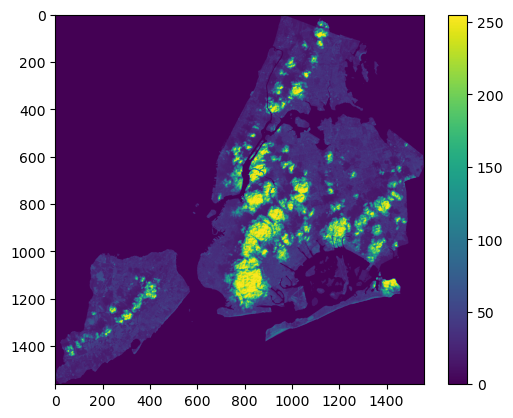

In [6]:
import rasterio
import matplotlib.pyplot as plt

file_path = '/Users/zhuangjunling/Documents/GitHub/Visualizing-policy-effects-on-neighborhoods/nyc-lst-ndvi-main/02-data/landsat_clipped_nyc/clipped_nyc_LT05_L1TP_013032_19850917_20161004_01_T1_B3.TIF'

# 打开文件并读取数据
with rasterio.open(file_path) as src:
    img_data = src.read(1)

# 使用 matplotlib 绘制图像
plt.imshow(img_data, cmap='viridis')
plt.colorbar()
plt.show()

#### Plot results

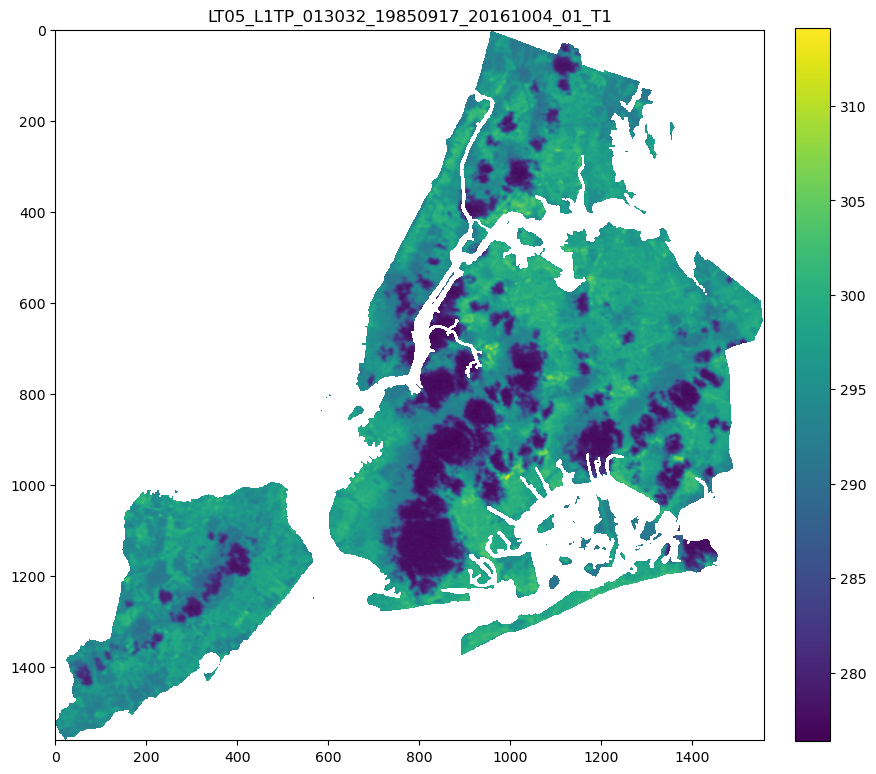

In [7]:
# Plot the test band
object_to_plot = lst # OPTIONS: lst, ndvi, bandX_test, toa, bt, vf, emiss
##########################################################################
fig = plt.figure(figsize=(10, 10))
im = plt.imshow(object_to_plot)#, cmap="RdYlBu")#,vmin=-1,vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title(get_landsat_identifier(band6_filenames[select]))
# plt.savefig(DIR_FIGS + "/lst_"+get_landsat_identifier(\
                                        # band6_filenames[select]) + ".png")
plt.show()

In [24]:
import rasterio

with rasterio.open('lst_geotiff.tif', 'w', driver='GTiff', height=lst.shape[0], width=lst.shape[1], count=1, dtype=lst.dtype, crs=lst.rio.crs.to_string(), transform=lst.rio.transform()) as dst:
    dst.write(lst.values, 1)


ERROR 1: PROJ: internal_proj_identify: /Users/zhuangjunling/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [31]:
import geopandas as gpd
from rasterstats import zonal_stats

# 加载 NTA 数据集（例如：nta_gdf）
nta_gdf = gpd.read_file("./MH_Selected_Area.geojson")
nta_gdf
# 确保 NTA 数据集具有与 LST 数据相同的坐标参考系统
nta_gdf = nta_gdf.to_crs(lst.rio.crs.to_string())

# 使用 zonal_stats 函数计算每个 NTA 区域的平均 LST
nta_zonal_stats = zonal_stats(nta_gdf, 'lst_geotiff.tif', stats="mean")

# 将平均 LST 添加到 NTA GeoDataFrame
nta_gdf['mean_lst'] = [x['mean'] for x in nta_zonal_stats]
nta_gdf

,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geometry
0,1,Manhattan,061,MN0202,Greenwich Village,GrnwchVlg,0,MN02,MN02 Greenwich Village-SoHo (CD 2 Equivalent),12973.127921,1.060556e+07,"MULTIPOLYGON (((987048.270 206851.147, 987057...."
1,1,Manhattan,061,MN0203,West Village,WstVlg,0,MN02,MN02 Greenwich Village-SoHo (CD 2 Equivalent),21502.312334,1.429267e+07,"MULTIPOLYGON (((985125.733 207917.071, 984986...."
2,1,Manhattan,061,MN0303,East Village,EstVlg,0,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),21672.414892,1.897769e+07,"MULTIPOLYGON (((993355.892 200980.164, 993519...."
3,1,Manhattan,061,MN0401,Chelsea-Hudson Yards,Chls_HdsYd,0,MN04,MN04 Chelsea-Hell's Kitchen (CD 4 Approximation),40095.235613,2.967175e+07,"MULTIPOLYGON (((983754.618 217001.185, 983857...."
4,1,Manhattan,061,MN0402,Hell's Kitchen,HllsKtchn,0,MN04,MN04 Chelsea-Hell's Kitchen (CD 4 Approximation),34651.527343,1.838232e+07,"MULTIPOLYGON (((985324.423 221001.900, 985817...."
5,1,Manhattan,061,MN0501,Midtown South-Flatiron-Union Square,MdtwnSth,0,MN05,MN05 Midtown-Flatiron-Union Square (CD 5 Appro...,18800.765970,1.487811e+07,"MULTIPOLYGON (((989555.974 211702.854, 989420...."
6,1,Manhattan,061,MN0502,Midtown-Times Square,Mdtwn_TmSq,0,MN05,MN05 Midtown-Flatiron-Union Square (CD 5 Appro...,21258.401371,2.455251e+07,"MULTIPOLYGON (((991725.244 217725.299, 992169...."
7,1,Manhattan,061,MN0601,Stuyvesant Town-Peter Cooper Village,StyTwn,0,MN06,MN06 East Midtown-Murray Hill (CD 6 Approximat...,11061.819470,5.575563e+06,"MULTIPOLYGON (((994681.406 203127.675, 994780...."
8,1,Manhattan,061,MN0602,Gramercy,Grmrcy,0,MN06,MN06 East Midtown-Murray Hill (CD 6 Approximat...,12096.890854,7.526916e+06,"MULTIPOLYGON (((990196.892 207745.371, 990187...."
9,1,Manhattan,061,MN0603,Murray Hill-Kips Bay,MryHl_KpBy,0,MN06,MN06 East Midtown-Murray Hill (CD 6 Approximat...,23944.800238,1.577115e+07,"MULTIPOLYGON (((994980.207 205295.575, 994980...."


In [26]:
lst.rio.crs.to_string()

ERROR 1: PROJ: internal_proj_identify: /Users/zhuangjunling/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


'PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [27]:
nta_gdf.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

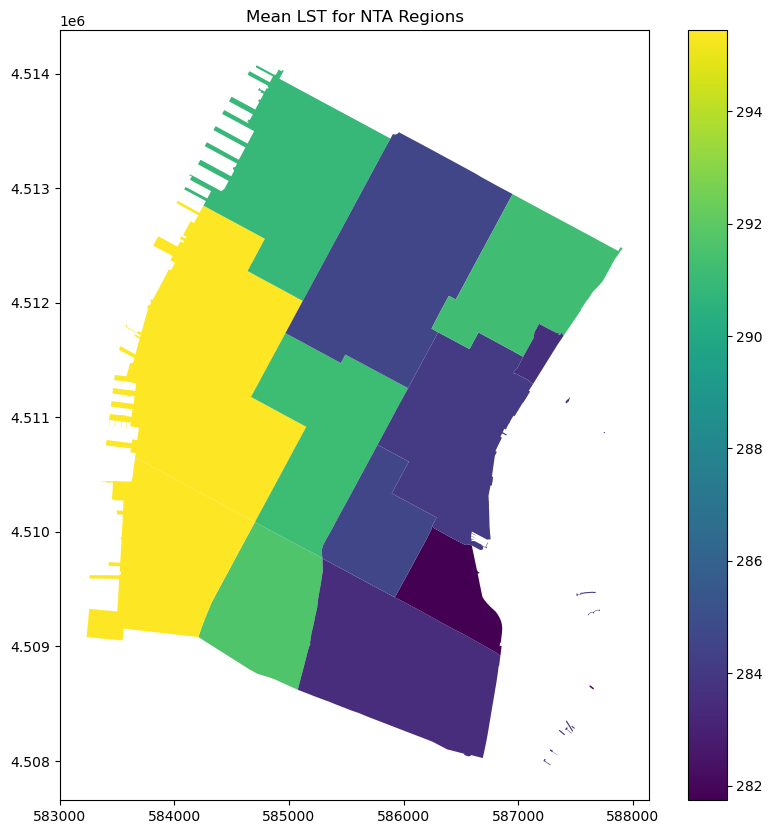

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nta_gdf.plot(column='mean_lst', cmap='viridis', legend=True, ax=ax)
plt.title("Mean LST for NTA Regions")
plt.show()


In [29]:
nta_gdf['mean_lst_celsius'] = nta_gdf['mean_lst'] - 273.15
nta_gdf = nta_gdf.drop(11)

nta_gdf

,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geometry,mean_lst,mean_lst_celsius
0,1,Manhattan,061,MN0202,Greenwich Village,GrnwchVlg,0,MN02,MN02 Greenwich Village-SoHo (CD 2 Equivalent),12973.127921,1.060556e+07,"MULTIPOLYGON (((585291.423 4509768.118, 585295...",291.689182,18.539182
1,1,Manhattan,061,MN0203,West Village,WstVlg,0,MN02,MN02 Greenwich Village-SoHo (CD 2 Equivalent),21502.312334,1.429267e+07,"MULTIPOLYGON (((584701.952 4510086.219, 584660...",295.443633,22.293633
2,1,Manhattan,061,MN0303,East Village,EstVlg,0,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),21672.414892,1.897769e+07,"MULTIPOLYGON (((587233.649 4508001.188, 587283...",283.477977,10.327977
3,1,Manhattan,061,MN0401,Chelsea-Hudson Yards,Chls_HdsYd,0,MN04,MN04 Chelsea-Hell's Kitchen (CD 4 Approximation),40095.235613,2.967175e+07,"MULTIPOLYGON (((584252.655 4512849.269, 584284...",295.390470,22.240470
4,1,Manhattan,061,MN0402,Hell's Kitchen,HllsKtchn,0,MN04,MN04 Chelsea-Hell's Kitchen (CD 4 Approximation),34651.527343,1.838232e+07,"MULTIPOLYGON (((584717.061 4514073.686, 584868...",290.935318,17.785318
5,1,Manhattan,061,MN0501,Midtown South-Flatiron-Union Square,MdtwnSth,0,MN05,MN05 Midtown-Flatiron-Union Square (CD 5 Appro...,18800.765970,1.487811e+07,"MULTIPOLYGON (((586038.650 4511255.077, 585998...",291.142211,17.992211
6,1,Manhattan,061,MN0502,Midtown-Times Square,Mdtwn_TmSq,0,MN05,MN05 Midtown-Flatiron-Union Square (CD 5 Appro...,21258.401371,2.455251e+07,"MULTIPOLYGON (((586678.691 4513097.575, 586814...",284.611729,11.461729
7,1,Manhattan,061,MN0601,Stuyvesant Town-Peter Cooper Village,StyTwn,0,MN06,MN06 East Midtown-Murray Hill (CD 6 Approximat...,11061.819470,5.575563e+06,"MULTIPOLYGON (((587630.068 4508660.108, 587660...",281.738232,8.588232
8,1,Manhattan,061,MN0602,Gramercy,Grmrcy,0,MN06,MN06 East Midtown-Murray Hill (CD 6 Approximat...,12096.890854,7.526916e+06,"MULTIPOLYGON (((586247.666 4510051.504, 586245...",284.578331,11.428331
9,1,Manhattan,061,MN0603,Murray Hill-Kips Bay,MryHl_KpBy,0,MN06,MN06 East Midtown-Murray Hill (CD 6 Approximat...,23944.800238,1.577115e+07,"MULTIPOLYGON (((587713.587 4509321.680, 587713...",284.095885,10.945885


In [32]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from pyproj import Transformer

src_epsg = "EPSG:32618"
transformer = Transformer.from_crs(src_epsg, "EPSG:4326", always_xy=True)

# 定义转换函数
def transform_polygon(polygon):
    exterior_coords = [(lon, lat) for lon, lat in transformer.itransform(polygon.exterior.coords)]
    interiors = []
    for interior in polygon.interiors:
        interior_coords = [(lon, lat) for lon, lat in transformer.itransform(interior.coords)]
        interiors.append(interior_coords)
    return Polygon(exterior_coords, interiors)

def transform_multipolygon(multipolygon):
    return MultiPolygon([transform_polygon(polygon) for polygon in multipolygon])

# 将坐标转换为WGS84经纬度坐标
nta_gdf["geometry"] = nta_gdf["geometry"].apply(lambda geom: transform_multipolygon(geom) if isinstance(geom, MultiPolygon) else transform_polygon(geom))
nta_gdf

/var/folders/c1/53w1t4lx07x61mckxl8cl4nh0000gn/T/ipykernel_34573/2870642114.py:18: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return MultiPolygon([transform_polygon(polygon) for polygon in multipolygon])


,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geometry
0,1,Manhattan,061,MN0202,Greenwich Village,GrnwchVlg,0,MN02,MN02 Greenwich Village-SoHo (CD 2 Equivalent),12973.127921,1.060556e+07,"MULTIPOLYGON (((-70.62499 1.86595, -70.62491 1..."
1,1,Manhattan,061,MN0203,West Village,WstVlg,0,MN02,MN02 Greenwich Village-SoHo (CD 2 Equivalent),21502.312334,1.429267e+07,"MULTIPOLYGON (((-70.64220 1.87561, -70.64345 1..."
2,1,Manhattan,061,MN0303,East Village,EstVlg,0,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),21672.414892,1.897769e+07,"MULTIPOLYGON (((-70.56858 1.81286, -70.56711 1..."
3,1,Manhattan,061,MN0401,Chelsea-Hudson Yards,Chls_HdsYd,0,MN04,MN04 Chelsea-Hell's Kitchen (CD 4 Approximation),40095.235613,2.967175e+07,"MULTIPOLYGON (((-70.65429 1.95759, -70.65337 1..."
4,1,Manhattan,061,MN0402,Hell's Kitchen,HllsKtchn,0,MN04,MN04 Chelsea-Hell's Kitchen (CD 4 Approximation),34651.527343,1.838232e+07,"MULTIPOLYGON (((-70.64012 1.99365, -70.63571 1..."
5,1,Manhattan,061,MN0501,Midtown South-Flatiron-Union Square,MdtwnSth,0,MN05,MN05 Midtown-Flatiron-Union Square (CD 5 Appro...,18800.765970,1.487811e+07,"MULTIPOLYGON (((-70.60240 1.90966, -70.60362 1..."
6,1,Manhattan,061,MN0502,Midtown-Times Square,Mdtwn_TmSq,0,MN05,MN05 Midtown-Flatiron-Union Square (CD 5 Appro...,21258.401371,2.455251e+07,"MULTIPOLYGON (((-70.58281 1.96394, -70.57883 1..."
7,1,Manhattan,061,MN0601,Stuyvesant Town-Peter Cooper Village,StyTwn,0,MN06,MN06 East Midtown-Murray Hill (CD 6 Approximat...,11061.819470,5.575563e+06,"MULTIPOLYGON (((-70.55665 1.83220, -70.55576 1..."
8,1,Manhattan,061,MN0602,Gramercy,Grmrcy,0,MN06,MN06 East Midtown-Murray Hill (CD 6 Approximat...,12096.890854,7.526916e+06,"MULTIPOLYGON (((-70.59674 1.87395, -70.59683 1..."
9,1,Manhattan,061,MN0603,Murray Hill-Kips Bay,MryHl_KpBy,0,MN06,MN06 East Midtown-Murray Hill (CD 6 Approximat...,23944.800238,1.577115e+07,"MULTIPOLYGON (((-70.55392 1.85174, -70.55391 1..."


In [22]:
nta_gdf.to_file("./NTA_20161004_MeanLandSurfaceTemperature.geojson", driver="GeoJSON")

/Users/zhuangjunling/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Plot a histogram to see the distribution of the raw data. 

## 3. Export LST and NDVI for all dates <a id="export"></a>

In [8]:
for index in range(len(band6_filenames)):
    # Open bands and metadata file
    band6 = open_masked_band(band6_filenames[index], 0.0)
    band4 = open_masked_band(band4_filenames[index], 0.0)
    band3 = open_masked_band(band3_filenames[index], 0.0)
    mtl = open_mtl_file(band6_filenames[index])

    # Begin LST equations
    toa = compute_toa_radiance(band6, mtl)
    bt = compute_brightness_temp(toa, mtl)
    ndvi = compute_ndvi(band4, band3, mtl)
    vf = compute_vegetation_fraction(ndvi)
    emiss = compute_emissivity(vf)
    w = 11.45*10**-6 # Center of Band 6 = 10.40 - 12.50 µm
    lst = compute_lst(w, bt, emiss)

    suffix = get_landsat_identifier(band6_filenames[index]) + ".tif"
    exportname_lst = DIR_LST_CLIPPED_NYC + "/lst_" + suffix
    exportname_ndvi = DIR_NDVI_CLIPPED_NYC + "/ndvi_" + suffix

    print("Saving ", exportname_lst)
    print("Saving ", exportname_ndvi)
    lst.rio.to_raster(exportname_lst, driver="GTiff")
    ndvi.rio.to_raster(exportname_ndvi, driver="GTiff")    

Saving  /home/aderrasc/Documents/japa_final/02-data/lst_clipped_nyc/lst_LT05_L1TP_013032_19850901_20161004_01_T1.tif
Saving  /home/aderrasc/Documents/japa_final/02-data/ndvi_clipped_nyc/ndvi_LT05_L1TP_013032_19850901_20161004_01_T1.tif
Saving  /home/aderrasc/Documents/japa_final/02-data/lst_clipped_nyc/lst_LT05_L1TP_013032_19850917_20161004_01_T1.tif
Saving  /home/aderrasc/Documents/japa_final/02-data/ndvi_clipped_nyc/ndvi_LT05_L1TP_013032_19850917_20161004_01_T1.tif
Saving  /home/aderrasc/Documents/japa_final/02-data/lst_clipped_nyc/lst_LT05_L1TP_013032_19880621_20161002_01_T1.tif
Saving  /home/aderrasc/Documents/japa_final/02-data/ndvi_clipped_nyc/ndvi_LT05_L1TP_013032_19880621_20161002_01_T1.tif
Saving  /home/aderrasc/Documents/japa_final/02-data/lst_clipped_nyc/lst_LT05_L1TP_013032_19880808_20161002_01_T1.tif
Saving  /home/aderrasc/Documents/japa_final/02-data/ndvi_clipped_nyc/ndvi_LT05_L1TP_013032_19880808_20161002_01_T1.tif
Saving  /home/aderrasc/Documents/japa_final/02-data/lst_